In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import zipfile
import tarfile
import h5py
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
from itertools import zip_longest
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

## Functions

### load_images_from_dirs Function
This function is used to load image files from specified directories. It:

- Iterates through all directories and subdirectories.
- Looks for .png files.
- Opens and converts them into numpy arrays using PIL.
- Appends each image to a list and returns the list of images.

In [2]:
def load_images_from_dirs(directories):
    images = []
    for directory in directories:
        image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
        for file_name in image_files:
            file_path = os.path.join(directory, file_name)  # Create the full file path
            img = Image.open(file_path)  # Open the image file
            img = np.array(img)  # Convert PIL image to numpy array
            images.append(img)  # Add the image to the list

    return images

# Example usage:
#train_dirs = ['path/to/trainDir', 'path/to/trainDir/captured']  # Example directories


### PixelLabelDatastore Class
This class handles loading and processing pixel label data stored in .h5 files:

- Initialization: Takes a list of directories and class names to map pixel values to indices.
- load_pixel_labels_from_dirs: Loads the pixel labels from .h5 files, maps raw pixel values to sequential class indices, and then maps those indices to class names.
- map_pixel_values_to_indices: A helper method that maps raw pixel values to class indices.
- map_indices_to_class_names: Maps numeric labels to class names.
- get_original_labels and get_mapped_labels: These methods return the original numeric labels and the class names after mapping.

In [3]:
class PixelLabelDatastore:
    def __init__(self, directories, class_names):
        self.class_names = class_names
        self.pixel_label_ids = np.arange(len(class_names))  # Sequential IDs: 0, 1, 2, ...
        self.pixel_labels = self.load_pixel_labels_from_dirs(directories)

    def load_pixel_labels_from_dirs(self, directories):
        pixel_labels = []
        for directory in directories:
            if not os.path.exists(directory):
                print(f"Directory does not exist: {directory}")
                continue

            hfive_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
            for file_name in hfive_files:
                file_path = os.path.join(directory, file_name)
                if not os.path.exists(file_path):
                    print(f"File does not exist: {file_path}")
                    continue

                try:
                    with h5py.File(file_path, 'r') as hfive_file:
                        if 'labels' in hfive_file:
                            label_data = hfive_file['labels'][:]
                            # Map pixel values to numeric indices
                            numeric_labels = self.map_pixel_values_to_indices(label_data)
                            # Map numeric indices to class names
                            class_name_labels = self.map_indices_to_class_names(numeric_labels)
                            pixel_labels.append({
                                'original': numeric_labels,      # Numeric indices (0, 1, 2, ...)
                                'mapped': class_name_labels      # Class names ("Noise", "NR", ...)
                            })
                        else:
                            print(f"'labels' dataset not found in {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

        return pixel_labels

    def map_pixel_values_to_indices(self, label_data):
        # Map raw pixel values to sequential class indices (0, 1, 2, ...)
        raw_to_sequential = {raw: idx for idx, raw in enumerate(
            np.floor(np.arange(len(self.class_names)) / (len(self.class_names) - 1) * 255).astype(int)
        )}
        # Assign the "Unknown" class index (e.g., 3) to any value not in raw_to_sequential
        return np.vectorize(lambda x: raw_to_sequential.get(x, len(self.class_names) - 1))(label_data)

    def map_indices_to_class_names(self, numeric_labels):
        # Map numeric indices (0, 1, 2, ...) to class names
        return np.vectorize(lambda idx: self.class_names[idx])(numeric_labels)

    def get_original_labels(self):
        # Collect and return all original numeric labels
        return [sample['original'] for sample in self.pixel_labels]

    def get_mapped_labels(self):
        # Collect and return all mapped class name labels
        return [sample['mapped'] for sample in self.pixel_labels]

### process_params_and_filter_bw_mod Function
This function processes metadata from .mat files:

- Bandwidth and Modulation Mapping: It uses mappings for modulation types and bandwidth values to convert these into indices.
- Processing .mat Files: It loads .mat files, processes their parameters, and removes unnecessary fields (like Info). It then filters the data to include only bandwidth, modulation, SNR, and Doppler values.
- Handling Modulation and Bandwidth: The function checks for these values, maps them to their respective indices, and adds them to the dictionary of processed metadata.

In [4]:
import re
import os
import numpy as np
from scipy.io import loadmat

def process_params_and_filter_bw_mod(directories):
    processed_data = []

    rc_to_bw = {'R.2': 10, 'R.6': 5, 'R.7': 10, 'R.8': 15, 'R.9': 20}
    modulation_types = ["QPSK", "16QAM", "64QAM", "256QAM"]
    mod_type_to_index = {mod: idx for idx, mod in enumerate(modulation_types)}
    bandwidth_values = [5, 10, 15, 20, 25, 30, 40, 50]
    bw_to_index = {bw: idx for idx, bw in enumerate(bandwidth_values)}
    class_map = {'NR': 1, 'LTE': 0, 'LTE_NR': 2}  # Updated class map

    for directory in directories:
        if not os.path.exists(directory):
            print(f"Directory does not exist: {directory}")
            continue

        mat_files = [f for f in os.listdir(directory) if f.endswith('.mat')]

        for file_name in mat_files:
            file_path = os.path.join(directory, file_name)
            if not os.path.exists(file_path):
                print(f"File does not exist: {file_path}")
                continue

            try:
                match = re.search(r'(LTE_NR|NR|LTE)', file_name)
                class_label = match.group(1) if match else None
                class_index = class_map.get(class_label, None)
                
                mat_data = loadmat(file_path)
                params = mat_data.get('params', None)
                if params is None:
                    print(f"Skipping file (no 'params' data): {file_path}")
                    continue

                params_without_info = {}
                for field in params[0, 0].dtype.names:
                    if field != 'Info':
                        field_data = params[0, 0][field]
                        if field_data.shape == (1, 1) or (isinstance(field_data, np.ndarray) and field_data.shape == (1,)):
                            field_data = field_data.item()
                        if field == 'RC' and field_data in rc_to_bw:
                            field_data = rc_to_bw[field_data]
                            field = 'BW'
                        params_without_info[field] = field_data

                processed_data.append({
                    'file_name': file_name,
                    'img_class_label': class_index,
                    'params_without_info': params_without_info
                })

                filtered_fields = ['BW', 'Modulation', 'SNRdB', 'Doppler']
                filtered_data = {field: params_without_info.get(field) for field in filtered_fields}
                filtered_data['Modulation_Index'] = mod_type_to_index.get(filtered_data.get('Modulation'))
                filtered_data['BW_Index'] = bw_to_index.get(filtered_data.get('BW'))
                filtered_data['img_class_label'] = class_index

                processed_data[-1]['filtered'] = filtered_data
            
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return processed_data


### helper_spec_sense_partition_data Function
This function partitions the datasets into training, validation, and test sets:

- Input Validation: It ensures the input percentages sum to 100%.
- Shuffling: It randomly shuffles the dataset to ensure no bias in the splits.
- Data Partitioning: The data is partitioned based on the specified percentages (e.g., 70% training, 15% validation, and 15% test).
- Normalization: It normalizes the SNR and Doppler values to ensure they fall between 0 and 1.
- Returning Partitions: The function returns the partitioned datasets along with their respective metadata, including BW, Modulation, SNR, and Doppler.

In [5]:
import numpy as np
def helper_spec_sense_partition_data(imds, pxds, processed_metadata, parts):
    """
    Partitions the image and pixel label datasets into training and test subsets.
    Also returns the respective BW, Modulation types, SNR, Doppler values, and file names for each partition.

    Parameters:
        imds (list): List of images (numpy arrays).
        pxds (list): List of pixel label datasets (numpy arrays).
        processed_metadata (list): List of filtered metadata dictionaries containing 'BW', 'SNR', 'Doppler', and 'file_name'.
        parts (list): A 1x2 list of percentages [train, test].
                     The sum of the elements must equal 100.

    Returns:
        tuple:
        - images_train, labels_train: Training data subsets.
        - BW_train, SNR_train, Doppler_train, file_names_train: Training metadata.
        - images_test, labels_test: Test data subsets.
        - BW_test, SNR_test, Doppler_test, file_names_test: Test metadata.
    """

    #def transform_snr(snr_values):
    #    return np.log1p(snr_values)  # log(1 + SNR) transformation

    
    def normalize(values):
        min_val = np.min(values)
        max_val = np.max(values)
        normalized_values = (values - min_val) / (max_val - min_val)  # Min-Max normalization
        return normalized_values, min_val, max_val
    
    # Normalize SNR and Doppler values
    
    SNR = np.array([data['filtered']['SNRdB'] for data in processed_metadata])
    Doppler = np.array([data['filtered']['Doppler'] for data in processed_metadata])

    #snr_log = transform_snr(SNR)
    
    SNR_normalized, min_SNR, max_SNR = normalize(SNR)
    Doppler_normalized, min_Doppler, max_Doppler = normalize(Doppler)
    
    
    # Validate input
    if len(parts) != 2 or sum(parts) != 100:
        raise ValueError("Parts must be a list of two elements summing to 100.")

    # Set random seed for reproducibility
    np.random.seed(0)

    # Shuffle indices
    num_files = len(imds)
    shuffled_indices = np.random.permutation(num_files)

    # Compute split indices
    num_train = int(num_files * parts[0] / 100)

    # Split indices
    train_indices = shuffled_indices[:num_train]
    test_indices = shuffled_indices[num_train:]

    # Subset data
    def get_partition(indices, SNR_normalized, Doppler_normalized):
        images = [imds[i] for i in indices]
        labels = [pxds[i] for i in indices]
        metadata_subset = [processed_metadata[i]['filtered'] for i in indices]
        BW = [data['BW_Index'] for data in metadata_subset]
        SNR = SNR_normalized[indices]  # Use normalized SNR
        Doppler = Doppler_normalized[indices]  # Use normalized Doppler
        file_names = [processed_metadata[i]['file_name'] for i in indices]
        image_label = [data['img_class_label'] for data in metadata_subset]
        return images, labels, BW, SNR, Doppler, file_names, image_label
    
    

    # Get train and test partitions
    images_train, labels_train, BW_train, SNR_train, Doppler_train, file_names_train, image_label_train = get_partition(train_indices,SNR_normalized, Doppler_normalized)
    images_test, labels_test, BW_test, SNR_test, Doppler_test, file_names_test, image_label_test = get_partition(test_indices,SNR_normalized, Doppler_normalized)
    
    # Visualize the SNR distribution before normalization
    plt.figure(figsize=(8, 6))
    plt.hist(SNR_train, bins=30, alpha=0.7, label='Train SNR')
    plt.hist(SNR_test, bins=30, alpha=0.7, label='Test SNR')
    plt.title('SNR Distribution (Before Normalization)')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    for label, values in [("SNR_train", SNR_train), ("SNR_test", SNR_test), ("Doppler_train", Doppler_train), ("Doppler_test", Doppler_test)]:
        print(f"Stats for {label}:")
        print(f"  Min: {np.min(values):.4f}")
        print(f"  Max: {np.max(values):.4f}")
        print(f"  Mean: {np.mean(values):.4f}")
        print(f"  Std Dev: {np.std(values):.4f}")
        print(f"  Percentiles: 25th={np.percentile(values, 25)}, 50th (Median)={np.percentile(values, 50)}, 75th={np.percentile(values, 75)}")
        print("-" * 30)
       
    

    # Stack all original labels and images into single NumPy arrays for efficient tensor creation
    labels_train = np.stack([sample['original'] for sample in labels_train], axis=0)
    images_train = np.stack(images_train, axis=0)

    labels_test = np.stack([sample['original'] for sample in labels_test], axis=0)
    images_test = np.stack(images_test, axis=0)

    # Return data and metadata
    return (images_train, labels_train, BW_train, SNR_train, Doppler_train, file_names_train, image_label_train,
        images_test, labels_test, BW_test, SNR_test, Doppler_test, file_names_test, image_label_test,
        min_SNR, max_SNR, min_Doppler, max_Doppler)


In [6]:
def combine(imds, pxds, BW, snr, doppler, file_names, image_labels):
    """Combine image, pixel label, BW, modulation, SNR, Doppler, and file name datasets."""
    return list(zip(imds, pxds, BW, snr, doppler, file_names, image_labels))

### ImageLabelDataset Class
This is a custom dataset class derived from torch.utils.data.Dataset. It is used for PyTorch training:

Initialization: Takes in images, labels, bandwidths, modulation types, SNR, and Doppler values as inputs.
__len__: Returns the size of the dataset (i.e., the number of samples).

In [7]:
from torch.utils.data import Dataset

class ImageLabelDataset(Dataset):
    def __init__(self, images, labels, bandwidths,snr,doppler, file_names, image_labels):
        """
        Initializes the dataset.
        Args:
            images (torch.Tensor): Tensor of images.
            labels (torch.Tensor): Tensor of pixel-wise segmentation labels.
            bandwidths (torch.Tensor): Tensor of bandwidth class labels.
            snr (torch.Tensor): Tensor of SNR values.
            doppler (torch.Tensor): Tensor of Doppler values.
            file_names (list): List of file names corresponding to images.
        """
        self.images = images
        self.labels = labels
        self.bandwidths = bandwidths
        self.snr = snr
        self.doppler = doppler
        self.file_names = file_names
        self.image_labels = image_labels

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.images)
    

    def __getitem__(self, idx):
        """
        Fetches a single data point.
        Args:
            idx (int): Index of the data point.
        Returns:
            tuple: A tuple containing the image, segmentation label, bandwidth label, modulation type label, file name and image label.
        """
        image = self.images[idx]
        label = self.labels[idx]
        bandwidth = self.bandwidths[idx]
        snr = self.snr[idx]
        doppler = self.doppler[idx]
        file_name = self.file_names[idx]
        image_label = self.image_labels[idx]
        return image, label, bandwidth, snr, doppler, file_name,image_label


## Training Data directory and class setup

In [8]:
comb_data_dir = [r'C:\Users\mathu\OneDrive\Desktop\EEE Y4.S1\FYP\MATLAB data generation finalised\TrainingData\128x128\LTE_NR' 
                # r'C:\Users\mathu\OneDrive\Desktop\EEE Y4.S1\FYP\MATLAB data generation finalised\TrainingDatawithseq\128x128\LTE_NR',
                #r'C:\Users\mathu\OneDrive\Desktop\EEE Y4.S1\FYP\MATLAB data generation finalised\TrainingDatawithfeatures\128x128\LTE_NR'
                ]
class_names = ["Noise", "NR", "LTE" , "Unknown"]  # Define class names
modulation_types = ["QPSK", "16QAM", "64QAM", "256QAM"]
bandwidths = [5, 10, 15, 20, 25, 30, 40, 50]
num_classes = len(class_names)
num_bandwidths = len(bandwidths)
pixel_label_ids = np.floor(np.arange(num_classes) / (num_classes - 1) * 255).astype(int)

## Image datastore
A function that loads all .png images in each specified directory.
For each image, it:
- Collects file names ending in .png.
- Opens the image, converts it to a NumPy array, and appends it to images.
- This function will return a list of images (in NumPy array form) stored in training_images.


In [9]:
combined_images = load_images_from_dirs(comb_data_dir)
print(f"Loaded {len(combined_images)} images.")

Loaded 918 images.


## Pixel Label Datastore, loading pixels and mapping pixel value to classes

 Loads pixel label data from .h5 files, where each file is expected to contain a dataset named 'labels'.
For each .h5 file:
- It checks if the file contains a labels dataset.
- If labels are found, it reads them as a NumPy array and maps the pixel values to class names using map_pixel_values_to_classes.

The pixel_labels list stores the final mapped labels.

This function uses pixel_label_ids and class_names to create a dictionary mapping pixel values to class names.
It then maps each pixel value in label_data to a corresponding class, allowing the model to understand the label format.

In [10]:
# Load pixel labels using the updated PixelLabelDatastore class
pxds_truth_combined = PixelLabelDatastore(comb_data_dir, class_names)

# Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Loaded {len(pxds_truth_combined.pixel_labels)} sets of pixel labels.")


Loaded 918 sets of pixel labels.


In [11]:
processed_metadata_combined = process_params_and_filter_bw_mod(comb_data_dir)

   
    # Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Processed {len(processed_metadata_combined)} number of metadata files.")

Processed 918 number of metadata files.


In [12]:
processed_metadata_combined = sorted(processed_metadata_combined, key=lambda x: x['file_name'])

In [13]:
processed_metadata_combined[5]

{'file_name': 'LTE_NR_frame_101.mat',
 'img_class_label': 2,
 'params_without_info': {'SCS': 15,
  'BW': 20,
  'SNRdB': 28.564844241681683,
  'Doppler': 165.46965972595987,
  'TrBlkOff': 2},
 'filtered': {'BW': 20,
  'Modulation': None,
  'SNRdB': 28.564844241681683,
  'Doppler': 165.46965972595987,
  'Modulation_Index': None,
  'BW_Index': 3,
  'img_class_label': 2}}

In [14]:
# Extract all SNR values from the 'params_without_info' and 'filtered' fields
snr_values = [entry['params_without_info']['SNRdB'] for entry in processed_metadata_combined]


In [15]:
import numpy as np

# Convert snr_values to a numpy array for easy computation
snr_values = np.array(snr_values)

# Basic statistics
min_snr = np.min(snr_values)
max_snr = np.max(snr_values)
mean_snr = np.mean(snr_values)
std_snr = np.std(snr_values)
median_snr = np.median(snr_values)
percentiles = np.percentile(snr_values, [25, 50, 75])

# Print the statistics
print(f"Min SNR: {min_snr}")
print(f"Max SNR: {max_snr}")
print(f"Mean SNR: {mean_snr}")
print(f"Standard Deviation of SNR: {std_snr}")
print(f"Median SNR: {median_snr}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")


Min SNR: 2.7828036337496084e-05
Max SNR: 39.89831804202599
Mean SNR: 20.607690108255518
Standard Deviation of SNR: 11.511630746530681
Median SNR: 20.628478075239762
25th Percentile: 10.967156157097332
50th Percentile (Median): 20.628478075239762
75th Percentile: 30.918209785423922


In [16]:
from scipy.stats import skew, kurtosis
# Calculate skewness and kurtosis
snr_skew = skew(snr_values)
snr_kurtosis = kurtosis(snr_values)

print(f"Skewness: {snr_skew}")
print(f"Kurtosis: {snr_kurtosis}")

Skewness: -0.08753755241782972
Kurtosis: -1.1560040334535453


In [17]:
log_snr = np.log1p(snr_values)

In [18]:
from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis
log_snr_skew = skew(log_snr)
log_snr_kurtosis = kurtosis(log_snr)

print(f"Skewness: {log_snr_skew}")
print(f"Kurtosis: {log_snr_kurtosis}")


Skewness: -1.3818916644428043
Kurtosis: 1.4693913046772247


## Train test datasplit

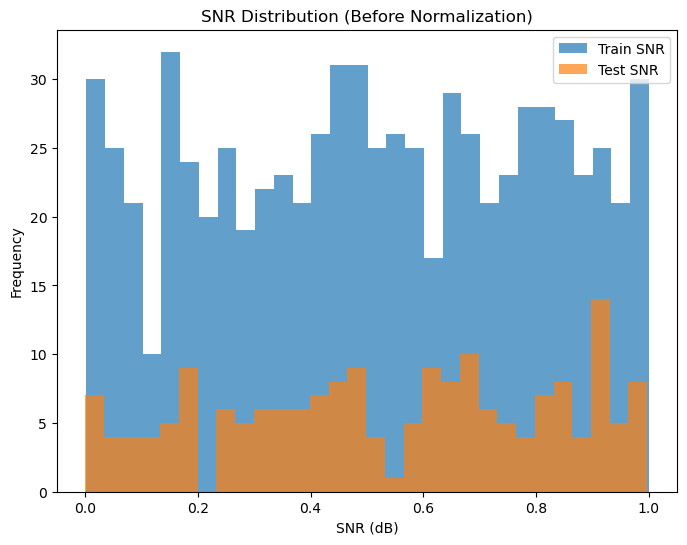

Stats for SNR_train:
  Min: 0.0018
  Max: 1.0000
  Mean: 0.5110
  Std Dev: 0.2885
  Percentiles: 25th=0.2638264431446447, 50th (Median)=0.5157204085017647, 75th=0.7662497531022349
------------------------------
Stats for SNR_test:
  Min: 0.0000
  Max: 0.9971
  Mean: 0.5385
  Std Dev: 0.2877
  Percentiles: 25th=0.31674364188157833, 50th (Median)=0.5676816447982338, 75th=0.7925130087102243
------------------------------
Stats for Doppler_train:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.5131
  Std Dev: 0.2851
  Percentiles: 25th=0.2753562316340986, 50th (Median)=0.5106700605883834, 75th=0.7672185391213829
------------------------------
Stats for Doppler_test:
  Min: 0.0006
  Max: 0.9953
  Mean: 0.5221
  Std Dev: 0.3049
  Percentiles: 25th=0.24600306761220708, 50th (Median)=0.5446290610906921, 75th=0.7902257328219993
------------------------------


In [19]:
# Partition data
parts = [80,20]
(images_train_comb, labels_train_comb, BW_train_comb, SNR_train_comb, Doppler_train_comb,file_names_train_comb,image_label_train_comb,
images_test_comb, labels_test_comb, BW_test_comb, SNR_test_comb, Doppler_test_comb, file_names_test_comb, image_label_test_comb,
min_SNR, max_SNR, min_Doppler, max_Doppler) =helper_spec_sense_partition_data(combined_images, pxds_truth_combined.pixel_labels, processed_metadata_combined, parts)

In [20]:
min_SNR

2.7828036337496084e-05

In [21]:
max_SNR

39.89831804202599

In [22]:
cds_train = combine(images_train_comb, labels_train_comb, BW_train_comb, SNR_train_comb, Doppler_train_comb,file_names_train_comb,image_label_train_comb)
cds_test = combine(images_test_comb, labels_test_comb, BW_test_comb, SNR_test_comb, Doppler_test_comb, file_names_test_comb, image_label_test_comb)

print(f"Training set: {len(cds_train)} pairs")
print(f"Test set: {len(cds_test)} pairs")


Training set: 734 pairs
Test set: 184 pairs


## PyTorch tensors conversion

In [23]:
# Now you can convert the stacked arrays to tensors
images_train_tensor = torch.tensor(images_train_comb, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train_comb, dtype=torch.long)
BW_train_tensor = torch.tensor(BW_train_comb, dtype=torch.long)
snr_train_tensor = torch.tensor(SNR_train_comb, dtype=torch.float32)
doppler_train_tensor = torch.tensor(Doppler_train_comb, dtype=torch.float32)
img_label_train_tensor = torch.tensor(image_label_train_comb, dtype=torch.long)


images_test_tensor = torch.tensor(images_test_comb, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test_comb, dtype=torch.long)
BW_test_tensor = torch.tensor(BW_test_comb, dtype=torch.long)
snr_test_tensor = torch.tensor(SNR_test_comb, dtype=torch.float32)
doppler_test_tensor = torch.tensor(Doppler_test_comb, dtype=torch.float32)
img_label_test_tensor = torch.tensor(image_label_test_comb, dtype=torch.long)

# Normalize images (after converting to tensors)
images_train_tensor = images_train_tensor / 255.0
images_train_tensor = images_train_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

images_test_tensor = images_test_tensor / 255.0
images_test_tensor = images_test_tensor.permute(0, 3, 1, 2)

# Example of tensor shapes
print(f"Training images tensor shape: {images_train_tensor.shape}")
print(f"Training labels tensor shape: {labels_train_tensor.shape}")
print(f"Training bandwidth tensor shape: {BW_train_tensor.shape}")
print(f"Training SNR shape: {snr_train_tensor.shape}")
print(f"Training Doppler tensor shape: {doppler_train_tensor.shape}")
print(f"Training image label tensor shape: {img_label_train_tensor.shape}")
print("-"*60)

print(f"Testing images tensor shape: {images_test_tensor.shape}")
print(f"Testing labels tensor shape: {labels_test_tensor.shape}")
print(f"Testing bandwidth tensor shape: {BW_test_tensor.shape}")
print(f"Testing SNR shape: {snr_test_tensor.shape}")
print(f"Testing Doppler tensor shape: {doppler_test_tensor.shape}")
print(f"Testing image label tensor shape: {img_label_test_tensor.shape}")

Training images tensor shape: torch.Size([734, 3, 128, 128])
Training labels tensor shape: torch.Size([734, 128, 128])
Training bandwidth tensor shape: torch.Size([734])
Training SNR shape: torch.Size([734])
Training Doppler tensor shape: torch.Size([734])
Training image label tensor shape: torch.Size([734])
------------------------------------------------------------
Testing images tensor shape: torch.Size([184, 3, 128, 128])
Testing labels tensor shape: torch.Size([184, 128, 128])
Testing bandwidth tensor shape: torch.Size([184])
Testing SNR shape: torch.Size([184])
Testing Doppler tensor shape: torch.Size([184])
Testing image label tensor shape: torch.Size([184])


## Data Loading

In [24]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = ImageLabelDataset(images=images_train_tensor, labels=labels_train_tensor, 
                                  bandwidths=BW_train_tensor, 
                                 snr=snr_train_tensor, doppler=doppler_train_tensor, file_names=file_names_train_comb, image_labels = img_label_train_tensor)

test_dataset = ImageLabelDataset(images=images_test_tensor, labels=labels_test_tensor, 
                                 bandwidths=BW_test_tensor, 
                                 snr=snr_test_tensor, doppler=doppler_test_tensor, file_names=file_names_test_comb, image_labels = img_label_test_tensor)


# Create DataLoaders
batch_size = 16  # You can adjust the batch size based on your available memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Alignement verification

In [25]:
# Verifying the alignment between the dataset and metadata (e.g., file names)
for idx in range(len(train_dataset)):
    _, _, _, _, _, file_name,_ = train_dataset[idx]
    assert file_name == file_names_train_comb[idx], f"Mismatch at index {idx}"
print("Train dataset and metadata are aligned!")

for idx in range(len(test_dataset)):
    _, _, _, _, _, file_name,_ = test_dataset[idx]
    assert file_name == file_names_test_comb[idx], f"Mismatch at index {idx}"
print("Test dataset and metadata are aligned!")


Train dataset and metadata are aligned!
Test dataset and metadata are aligned!


## DeepLab v3 + & SWIN tiny

### SWIN - tiny

In [26]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from segmentation_models_pytorch.losses import LovaszLoss, DiceLoss, JaccardLoss


# Define your loss functions
lovasz_loss = LovaszLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss()  # CrossEntropyLoss without weights initially
dice_loss = DiceLoss(mode='multiclass')
jaccard_loss = JaccardLoss(mode='multiclass')

# Custom function to combine the losses
def combined_loss(preds, targets):
    return jaccard_loss(preds, targets) + ce_loss(preds, targets)

# Training function
def train_model(train_loader, deeplab_model, num_classes, num_epochs, learning_rate, step_size, gamma, device=None):
    # Optimizer
    optimizer_deeplab = torch.optim.AdamW(deeplab_model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler_deeplab = StepLR(optimizer_deeplab, step_size=step_size, gamma=gamma)

    # Mixed precision scaler
    scaler = GradScaler()

    # Loop through epochs
    for epoch in range(num_epochs):
        deeplab_model.train()
        running_segmentation_loss = 0.0
        epoch_loss = 0.0  # Track the loss for scheduler

        # Progress bar
        epoch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, labels, bandwidths, snr, doppler, file_names, image_labels in epoch_progress:
            # Move images and labels to device
            original_images = images.to(device)  # No transformation applied for DeepLabV3+
            labels = labels.to(device)  # Labels for segmentation

            # Calculate class weights dynamically for each batch
            unique_classes, class_counts = torch.unique(labels, return_counts=True)
            class_weights = 1.0 / class_counts.float()
            class_weights /= class_weights.sum()  # Normalize so weights sum to 1
            class_weights = class_weights.to(device)

            # Use the class weights for CrossEntropyLoss
            ce_loss = nn.CrossEntropyLoss(weight=class_weights)

            # Zero gradients
            optimizer_deeplab.zero_grad()

            # Mixed precision
            with autocast():
                # Forward pass through DeepLabV3+ for segmentation and classification
                segmentation_output = deeplab_model(original_images)  # Pass original images for DeepLabV3+
                
                # Compute losses
                loss_segmentation = combined_loss(segmentation_output, labels)  # Compute combined loss

                # Combine losses for segmentation and classification
                total_loss = loss_segmentation

            # Backward pass for DeepLabV3+
            scaler.scale(total_loss).backward()
            scaler.step(optimizer_deeplab)

            # Update scaler
            scaler.update()

            # Accumulate losses
            running_segmentation_loss += loss_segmentation.item()

            # Accumulate the total loss for this batch
            epoch_loss += total_loss.item()

            # Update progress bar
            epoch_progress.set_postfix(
                segmentation_loss=running_segmentation_loss / len(epoch_progress)
            )

        # Step scheduler
        scheduler_deeplab.step()

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Segmentation Loss: {running_segmentation_loss/len(train_loader):.4f}")

    return deeplab_model


In [27]:
import segmentation_models_pytorch as smp

num_classes = len(torch.unique(labels_train_tensor))  # Number of segmentation classes
#num_image_classes = len(torch.unique(img_label_train_tensor))  # Number of image-level classes

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
deeplab_model = smp.DeepLabV3Plus(
    encoder_name="resnet101", 
    encoder_weights="imagenet",
    encoder_output_stride=8,
    in_channels=3, 
    classes=num_classes,  # Number of output classes
    activation=None  # Set activation to None for Grad-CAM

).to(device)


train_model(train_loader, deeplab_model, num_classes=len(torch.unique(labels_train_tensor)), num_epochs=15, 
            learning_rate= 0.00026297713714394443, step_size=8, gamma=0.5185031123909559, device=device)

C:\Users\mathu\AppData\Local\Temp\ipykernel_13732\3484006927.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mathu\AppData\Local\Temp\ipykernel_13732\3484006927.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15 - Segmentation Loss: 1.4421


Epoch 2/15 - Segmentation Loss: 0.7979


Epoch 3/15 - Segmentation Loss: 0.6129


Epoch 4/15 - Segmentation Loss: 0.4727


Epoch 5/15 - Segmentation Loss: 0.4353


Epoch 6/15 - Segmentation Loss: 0.3574


Epoch 7/15 - Segmentation Loss: 0.3242


Epoch 8/15 - Segmentation Loss: 0.2817


Epoch 9/15 - Segmentation Loss: 0.2312


Epoch 10/15 - Segmentation Loss: 0.1936


Epoch 11/15 - Segmentation Loss: 0.1777


Epoch 12/15 - Segmentation Loss: 0.1558


Epoch 13/15 - Segmentation Loss: 0.1518


Epoch 14/15 - Segmentation Loss: 0.1346


Epoch 15/15 - Segmentation Loss: 0.1223


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [28]:
from torchinfo import summary

summary(deeplab_model, input_size=(1, 3, 128, 128), depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 128, 128]          --
├─ResNetEncoder: 1-1                                    [1, 3, 128, 128]          --
│    └─Conv2d: 2-1                                      [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 64, 64]           128
│    └─ReLU: 2-3                                        [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                                   [1, 64, 32, 32]           --
│    └─Sequential: 2-5                                  [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                             [1, 256, 32, 32]          75,008
│    │    └─Bottleneck: 3-2                             [1, 256, 32, 32]          70,400
│    │    └─Bottleneck: 3-3                             [1, 256, 32, 32]          70,400
│    └─Sequential: 2-6                      

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure you've imported or defined these custom loss functions
# from custom_losses import LovaszLoss, DiceLoss, JaccardLoss

def calculate_per_image_pixel_accuracy(predictions, labels):
    """
    Calculate the pixel-wise accuracy for each image in the batch.
    """
    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()

    correct_pixels = (predictions_flat == labels_flat).sum()
    total_pixels = labels_flat.shape[0]

    accuracy = correct_pixels / total_pixels
    return accuracy

# Loss functions (ensure you have them defined or imported)
lovasz_loss = LovaszLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(mode='multiclass')
jaccard_loss = JaccardLoss(mode='multiclass')

def combined_loss(preds, targets):
    return jaccard_loss(preds, targets) + ce_loss(preds, targets)

def evaluate_model_with_snr_prediction_with_stats(deeplab_model, test_loader, device, num_classes):
    criterion_segmentation = combined_loss  # For segmentation
    deeplab_model.eval()

    running_segmentation_loss = 0.0
    all_segmentation_preds = []
    all_segmentation_labels = []
    per_image_accuracy_dict = {}

    images_list = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Validation', unit='batch'):
            images, labels, _, snr, _, file_names, image_labels = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            segmentation_output = deeplab_model(images)

            # Loss computation
            loss_segmentation = criterion_segmentation(segmentation_output, labels)
            running_segmentation_loss += loss_segmentation.item()

            # Collect predictions and labels
            segmentation_preds = torch.argmax(segmentation_output, dim=1)
            all_segmentation_preds.append(segmentation_preds.cpu().numpy())
            all_segmentation_labels.append(labels.cpu().numpy())

            # Image for visualization (if needed)
            images_list.append(images.cpu().numpy())

            # Calculate per-image pixel accuracy
            batch_accuracies = []
            for i in range(segmentation_preds.size(0)):
                accuracy = calculate_per_image_pixel_accuracy(segmentation_preds[i], labels[i])
                batch_accuracies.append(accuracy)

            for i, file_name in enumerate(file_names):
                per_image_accuracy_dict[file_name] = {
                    'accuracy': batch_accuracies[i],
                    'image': images[i].cpu().numpy(),
                    'segmentation_pred': segmentation_preds[i].cpu().numpy(),
                    'segmentation_label': labels[i].cpu().numpy()
                }

    # Convert to numpy arrays
    all_segmentation_preds = np.concatenate(all_segmentation_preds)
    all_segmentation_labels = np.concatenate(all_segmentation_labels)

    # Compute segmentation metrics
    segmentation_accuracy = (all_segmentation_preds == all_segmentation_labels).mean()
    segmentation_f1 = f1_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')
    segmentation_precision = precision_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)
    segmentation_recall = recall_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted', zero_division=1)

    # Compute IoU using jaccard_score from sklearn
    segmentation_iou = jaccard_score(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), average='weighted')

    avg_segmentation_loss = running_segmentation_loss / len(test_loader)

    print(f"Validation Loss - Segmentation: {avg_segmentation_loss:.4f}")
    print(f"Segmentation Metrics - Accuracy: {segmentation_accuracy:.4f}, F1: {segmentation_f1:.4f}, Precision: {segmentation_precision:.4f}, Recall: {segmentation_recall:.4f}")
    print(f"Segmentation IoU: {segmentation_iou:.4f}")

    return {
        "segmentation_loss": avg_segmentation_loss,
        "segmentation_metrics": {
            "accuracy": segmentation_accuracy,
            "f1": segmentation_f1,
            "precision": segmentation_precision,
            "recall": segmentation_recall,
            "iou": segmentation_iou
        },
        "per_image_accuracy_dict": per_image_accuracy_dict
    }, all_segmentation_preds, all_segmentation_labels, images_list, labels, per_image_accuracy_dict


In [30]:
metrics, all_segmentation_preds, all_segmentation_labels, images_list, labels,per_image_accuracy_dict = evaluate_model_with_snr_prediction_with_stats(
    deeplab_model, test_loader, device, num_classes
)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.25batch/s]


Validation Loss - Segmentation: 0.2407
Segmentation Metrics - Accuracy: 0.9530, F1: 0.9529, Precision: 0.9532, Recall: 0.9530
Segmentation IoU: 0.9103


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, jaccard_score
import numpy as np

def evaluate_segmentation_errors(all_segmentation_preds, all_segmentation_labels, class_names):
    """
    Perform error analysis on segmentation predictions.
    - Computes IoU per class.
    - Generates a confusion matrix.
    - Displays sample misclassifications.
    """

    num_classes = len(class_names)

    # Compute Intersection over Union (IoU) per class
    ious = []
    for i in range(num_classes):
        iou = jaccard_score((all_segmentation_labels == i).flatten(),
                            (all_segmentation_preds == i).flatten(), zero_division=1)
        ious.append(iou)

    print("\nPer-Class IoU Scores:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {ious[i]:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_segmentation_labels.flatten(), all_segmentation_preds.flatten(), labels=range(num_classes))

    # Normalize confusion matrix by row (sum of each row)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]  # Sum of each row
    cm_normalized = cm.astype('float') / cm_sum
    cm_normalized = np.nan_to_num(cm_normalized * 100)  # Handle NaN values by converting them to 0%

    # Plot confusion matrix as a heatmap with percentage sign
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Segmentation Confusion Matrix (Percentage)")
    plt.show()

    return ious



Per-Class IoU Scores:
Noise: 0.8853
NR: 0.9170
LTE: 0.9445
Unknown: 1.0000


C:\Users\mathu\AppData\Local\Temp\ipykernel_13732\3842618419.py:32: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm_sum


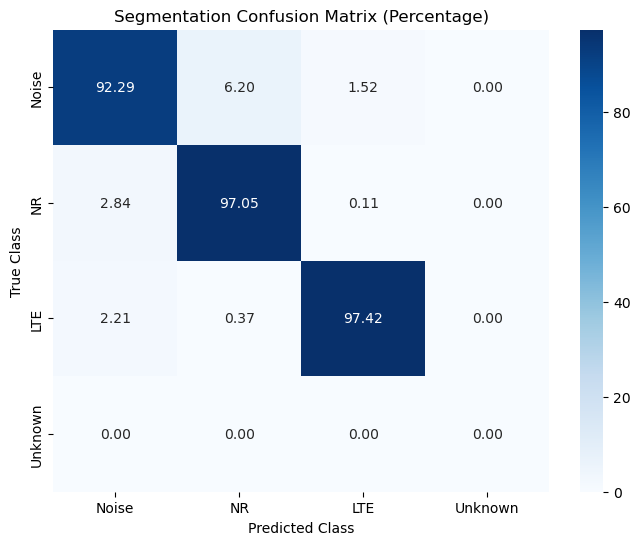

In [32]:
ious = evaluate_segmentation_errors(all_segmentation_preds, all_segmentation_labels, class_names)


In [33]:
# Extract file names and accuracies from the dictionary
file_names = list(per_image_accuracy_dict.keys())
accuracies = [entry['accuracy'] for entry in per_image_accuracy_dict.values()]

# Sort the list based on accuracy in descending order
ranked_accuracies = sorted(zip(file_names, accuracies), key=lambda x: x[1], reverse=True)

# Display the top-ranked accuracies
for rank, (file_name, accuracy) in enumerate(ranked_accuracies, 1):
    print(f"Rank {rank}: {file_name} - Accuracy: {accuracy * 100:.2f}%")

Rank 1: LTE_NR_frame_507.mat - Accuracy: 99.86%
Rank 2: LTE_NR_frame_41.mat - Accuracy: 99.62%
Rank 3: LTE_NR_frame_272.mat - Accuracy: 99.56%
Rank 4: LTE_NR_frame_936.mat - Accuracy: 99.54%
Rank 5: LTE_NR_frame_80.mat - Accuracy: 99.54%
Rank 6: LTE_NR_frame_64.mat - Accuracy: 99.22%
Rank 7: LTE_NR_frame_650.mat - Accuracy: 99.21%
Rank 8: LTE_NR_frame_886.mat - Accuracy: 99.17%
Rank 9: LTE_NR_frame_640.mat - Accuracy: 99.07%
Rank 10: LTE_NR_frame_841.mat - Accuracy: 99.02%
Rank 11: LTE_NR_frame_401.mat - Accuracy: 98.98%
Rank 12: LTE_NR_frame_950.mat - Accuracy: 98.93%
Rank 13: LTE_NR_frame_183.mat - Accuracy: 98.68%
Rank 14: LTE_NR_frame_67.mat - Accuracy: 98.66%
Rank 15: LTE_NR_frame_79.mat - Accuracy: 98.58%
Rank 16: LTE_NR_frame_107.mat - Accuracy: 98.58%
Rank 17: LTE_NR_frame_466.mat - Accuracy: 98.58%
Rank 18: LTE_NR_frame_39.mat - Accuracy: 98.55%
Rank 19: LTE_NR_frame_491.mat - Accuracy: 98.46%
Rank 20: LTE_NR_frame_30.mat - Accuracy: 98.45%
Rank 21: LTE_NR_frame_707.mat - Accu

In [34]:
benchmark = 0.95
high_acc = 0
total_acc = 0
sum_acc = 0

# Iterate through the ranked_accuracies, where each item is (file_name, accuracy)
for file_name, acc in ranked_accuracies:  # file_name and accuracy
    acc_value = acc  # Accuracy is already extracted as a float
    if acc_value > benchmark:
        high_acc += 1
    total_acc += 1
    sum_acc += acc_value

fraction = high_acc / total_acc
avg = sum_acc / total_acc

print(f"Beyond benchmark: {high_acc}")
print(f"Total: {total_acc}")

print(f"Fraction: {fraction}")
print(f"Average Accuracy: {avg * 100:.2f}%")


Beyond benchmark: 113
Total: 184
Fraction: 0.6141304347826086
Average Accuracy: 95.30%


In [35]:
# Initialize lists for images, predictions, labels, and file names
images_list = []
all_segmentation_preds = [] 
all_segmentation_labels = []
file_names_list = []  # New list for storing file names
accuracies_list = []

# Iterate through the ranked_accuracies (which contains file_name and accuracy dict)
for file_name, accuracy_tensor in ranked_accuracies:
    # Retrieve the dictionary with image, prediction, and label using the file_name
    accuracy_info = per_image_accuracy_dict.get(file_name, None)
    
    if accuracy_info is not None:
        image = accuracy_info['image']  # Extract image from the dictionary
        segmentation_preds = accuracy_info['segmentation_pred']  # Extract predictions
        segmentation_labels = accuracy_info['segmentation_label']  # Extract labels
        accuracy = accuracy_info['accuracy']
        
        # Move tensor to CPU and convert it to a NumPy value
        accuracy = accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy
        
        images_list.append(image)  # Append image to list
        all_segmentation_preds.append(segmentation_preds)
        all_segmentation_labels.append(segmentation_labels)
        file_names_list.append(file_name)  # Append file name to the new list
        accuracies_list.append(accuracy)  # Append accuracy value to the list

# Flatten the images into a single array
flat_images_list = np.concatenate(images_list, axis=0)  # Shape: (184, C, H, W)

# Convert accuracies_list to a NumPy array (no need for .cpu() since it's already handled)
accuracies_list = np.array(accuracies_list)

# Now flat_images_list contains all the images in a flattened form, ready for visualization
# And file_names_list contains the corresponding file names
# accuracies_list is a NumPy array now


In [36]:
# Check the shape of images_list (assuming images_list is a list of numpy arrays)
print(f"Shape of flat_images_list: {np.array(flat_images_list).shape}")

# Check the shape of all_segmentation_preds
print(f"Shape of all_segmentation_preds: {np.array(all_segmentation_preds).shape}")

# Check the shape of all_segmentation_labels
print(f"Shape of all_segmentation_labels: {np.array(all_segmentation_labels).shape}")

print(f"Shape of file_names_list: {np.array(file_names_list).shape}")
# Now you can check the shape
print(f"Shape of accuracy_list: {accuracies_list.shape}")

Shape of flat_images_list: (552, 128, 128)
Shape of all_segmentation_preds: (184, 128, 128)
Shape of all_segmentation_labels: (184, 128, 128)
Shape of file_names_list: (184,)
Shape of accuracy_list: (184,)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def visualize_top_images(images_list, all_segmentation_preds, all_segmentation_labels, file_names_list, class_names, accuracies_list, top_n=10):
    """
    Visualizes the top and bottom N images along with their predicted and true masks, including a color legend for classes.

    Args:
        images_list (numpy.ndarray): Array of original images (N, C, H, W) or (N, H, W) if grayscale.
        all_segmentation_preds (numpy.ndarray): Array of predicted masks (N, H, W).
        all_segmentation_labels (numpy.ndarray): Array of ground truth masks (N, H, W).
        file_names_list (list): List of file names corresponding to the images.
        class_names (list): List of class names (e.g., ['Noise', 'NR', 'LTE', 'Unknown']).
        accuracies_list (list): List of accuracies corresponding to each image.
        top_n (int): Number of top and bottom images to display.

    Returns:
        None (Displays images in a matplotlib figure).
    """
    # Define hardcoded class colors (RGBA format or any other color format you prefer)
    class_colors = [
        (0.0, 0.0, 0.5),  # Noise (Dark Blue)
        (0.678, 0.847, 0.902),  # NR (Light Blue)
        (1.0, 1.0, 0.0),  # LTE (Yellow)
        (0.647, 0.165, 0.165),  # Unknown (Brown)
    ]
    
    # Create a custom colormap and normalize based on class colors
    cmap = colors.ListedColormap(class_colors)
    norm = colors.BoundaryNorm(boundaries=np.arange(len(class_colors) + 1), ncolors=len(class_colors))

    # Set up figure size to avoid overlap
    fig, axes = plt.subplots(top_n, 3, figsize=(10, top_n * 3))

    print("Top segmentation accuracies:")
    for i in range(top_n):
        # Get the image, predicted mask, true mask, file name, and accuracy for the top N images
        image = images_list[i]
        pred_mask = all_segmentation_preds[i]
        true_mask = all_segmentation_labels[i]
        file_name = file_names_list[i]
        accuracy = accuracies_list[i]  # Get the accuracy for this image

        # If image is (C, H, W), transpose it to (H, W, C)
        if image.ndim == 3 and image.shape[0] == 3:  
            image = np.transpose(image, (1, 2, 0))

        # Display Original Image
        cmap_image = "gray" if image.ndim == 2 else None  # Grayscale images
        axes[i, 0].imshow(image, cmap=cmap_image)
        axes[i, 0].set_title(f"Image {file_name}\nAccuracy: {accuracy*100:.2f}%")  # Display the accuracy from accuracies_list
        axes[i, 0].axis("off")

        # Display Predicted Mask with hardcoded colors
        cax1 = axes[i, 1].imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis("off")

        # Display True Mask with hardcoded colors
        cax2 = axes[i, 2].imshow(true_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 2].set_title("True Mask")
        axes[i, 2].axis("off")

    # Adjust layout to add space for legend at the top
    plt.subplots_adjust(top=0.85)  # Add space at the top for the legend

    # Add horizontal legend at the top of the entire plot (outside the subplots)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / len(class_colors)), markersize=10) for i in range(len(class_colors))]
    fig.legend(handles, class_names, loc="upper center", bbox_to_anchor=(0.6, 1.01), ncol=len(class_colors), title="Classes")

    plt.tight_layout()
    plt.show()


Top segmentation accuracies:


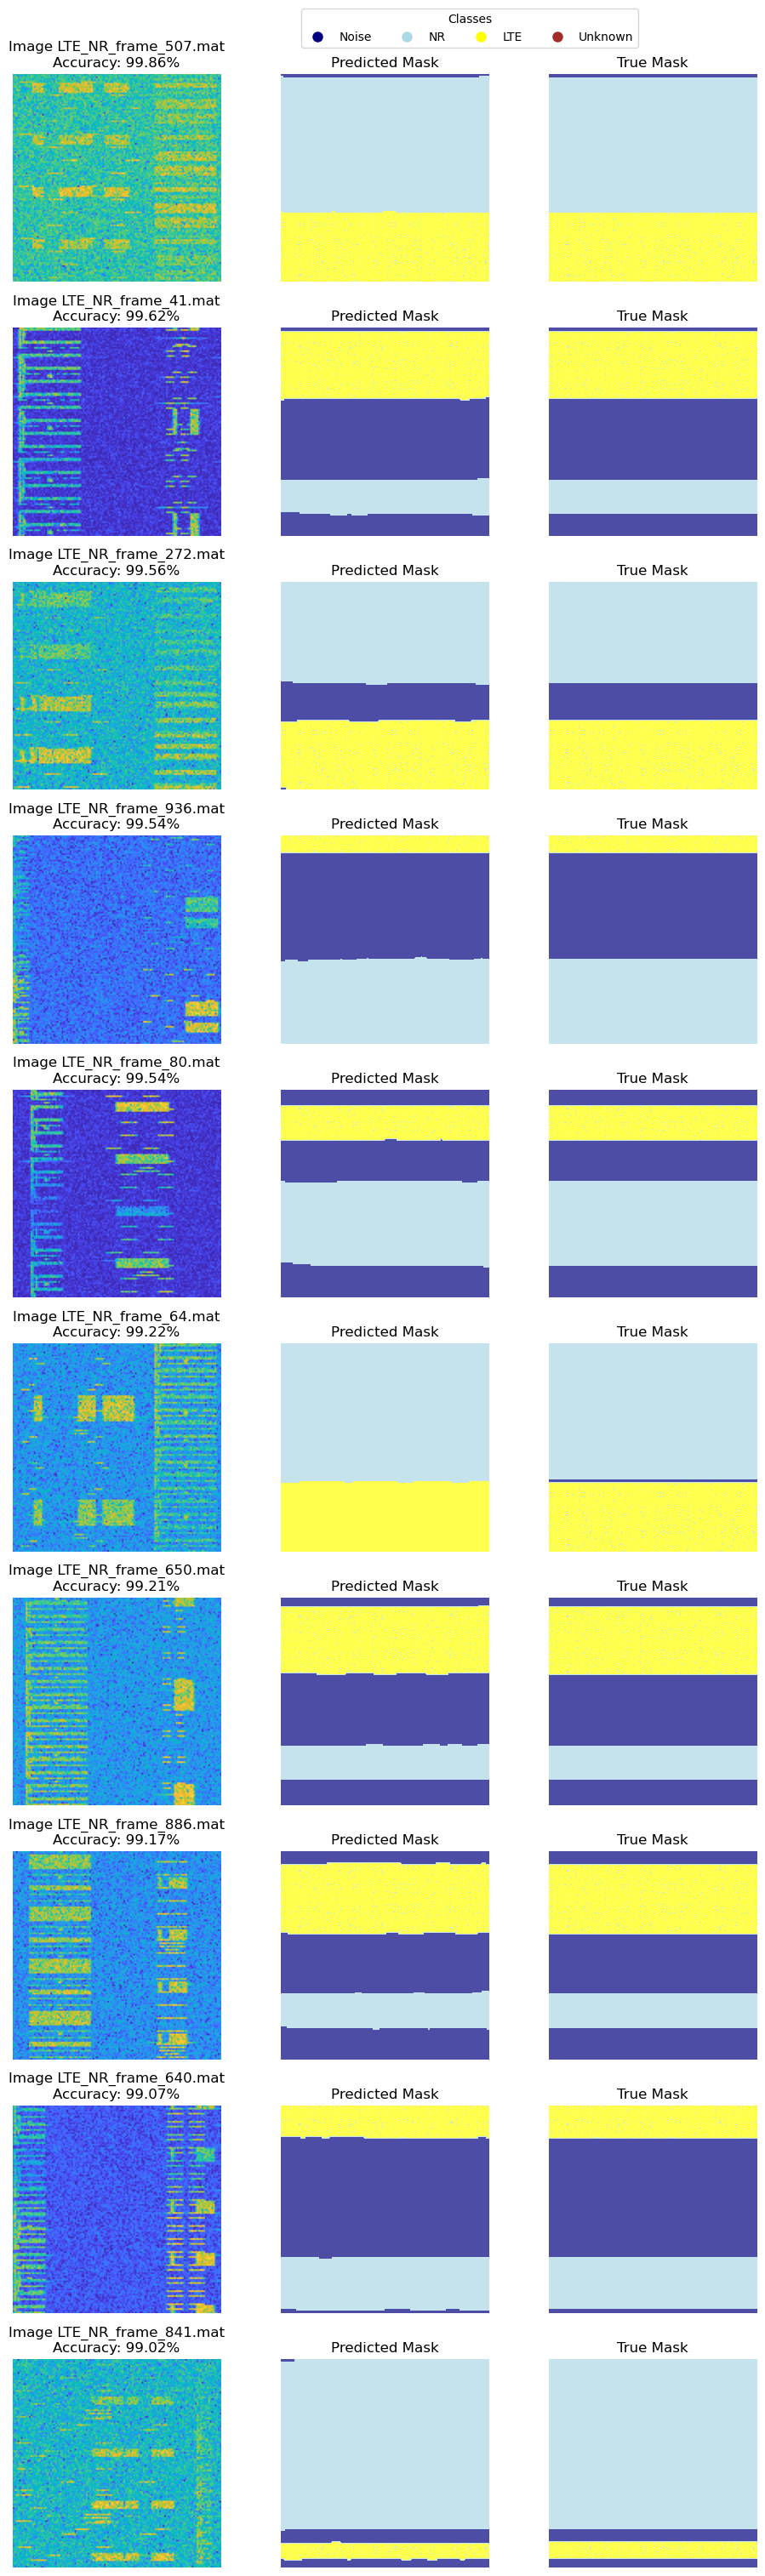

In [38]:
visualize_top_images(images_list, all_segmentation_preds, all_segmentation_labels, file_names_list, class_names, accuracies_list, top_n=10)


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def visualize_bottom_images(flat_images_list, all_segmentation_preds, all_segmentation_labels, accuracies_list, class_names, top_n=10):
    """
    Visualizes the top and bottom N images along with their predicted and true masks, including a color legend for classes.

    Args:
        flat_images_list (numpy.ndarray): Array of original images (N, C, H, W) or (N, H, W) if grayscale.
        all_segmentation_preds (numpy.ndarray): Array of predicted masks (N, H, W).
        all_segmentation_labels (numpy.ndarray): Array of ground truth masks (N, H, W).
        accuracies_list (list): List of accuracies corresponding to each image.
        class_names (list): List of class names (e.g., ['Noise', 'NR', 'LTE', 'Unknown']).
        top_n (int): Number of top and bottom images to display.

    Returns:
        None (Displays images in a matplotlib figure).
    """
    # Sort the accuracies in ascending order to get the bottom N
    bottom_indices = np.argsort(accuracies_list)[:top_n]  # Indices of bottom N images

    # Define hardcoded class colors (RGBA format or any other color format you prefer)
    class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
    (0.647, 0.165, 0.165),  # Unknown (Brown)
]

    
    # Create a custom colormap and normalize based on class colors
    cmap = colors.ListedColormap(class_colors)
    norm = colors.BoundaryNorm(boundaries=np.arange(len(class_colors) + 1), ncolors=len(class_colors))

    # Set up figure size to avoid overlap
    fig, axes = plt.subplots(top_n, 3, figsize=(10, top_n * 3))

    print("Bottom segmentation accuracies:")
    for i, idx in enumerate(bottom_indices):
        image = flat_images_list[idx]
        pred_mask = all_segmentation_preds[idx]
        true_mask = all_segmentation_labels[idx]
        file_name = file_names_list[idx]
        accuracy = accuracies_list[idx]  # Get the accuracy for this image

        # If image is (C, H, W), transpose it to (H, W, C)
        if image.ndim == 3 and image.shape[0] == 3:  
            image = np.transpose(image, (1, 2, 0))

        # Display Original Image
        cmap_image = "gray" if image.ndim == 2 else None  # Grayscale images
        axes[i, 0].imshow(image, cmap=cmap_image)
        axes[i, 0].set_title(f"Image {file_name}\nAccuracy: {accuracy*100:.2f}%")  # Display accuracy from accuracies_list
        axes[i, 0].axis("off")

        # Display Predicted Mask with hardcoded colors
        cax1 = axes[i, 1].imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis("off")

        # Display True Mask with hardcoded colors
        cax2 = axes[i, 2].imshow(true_mask, cmap=cmap, norm=norm, alpha=0.7)
        axes[i, 2].set_title("True Mask")
        axes[i, 2].axis("off")

    # Adjust layout to add space for legend at the top
    plt.subplots_adjust(top=0.85)  # Add space at the top for the legend

    # Add horizontal legend at the top of the entire plot (outside the subplots)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / len(class_colors)), markersize=10) for i in range(len(class_colors))]
    fig.legend(handles, class_names, loc="upper center", bbox_to_anchor=(0.6, 1.01), ncol=len(class_colors), title="Classes")

    plt.tight_layout()
    plt.show()


Bottom segmentation accuracies:


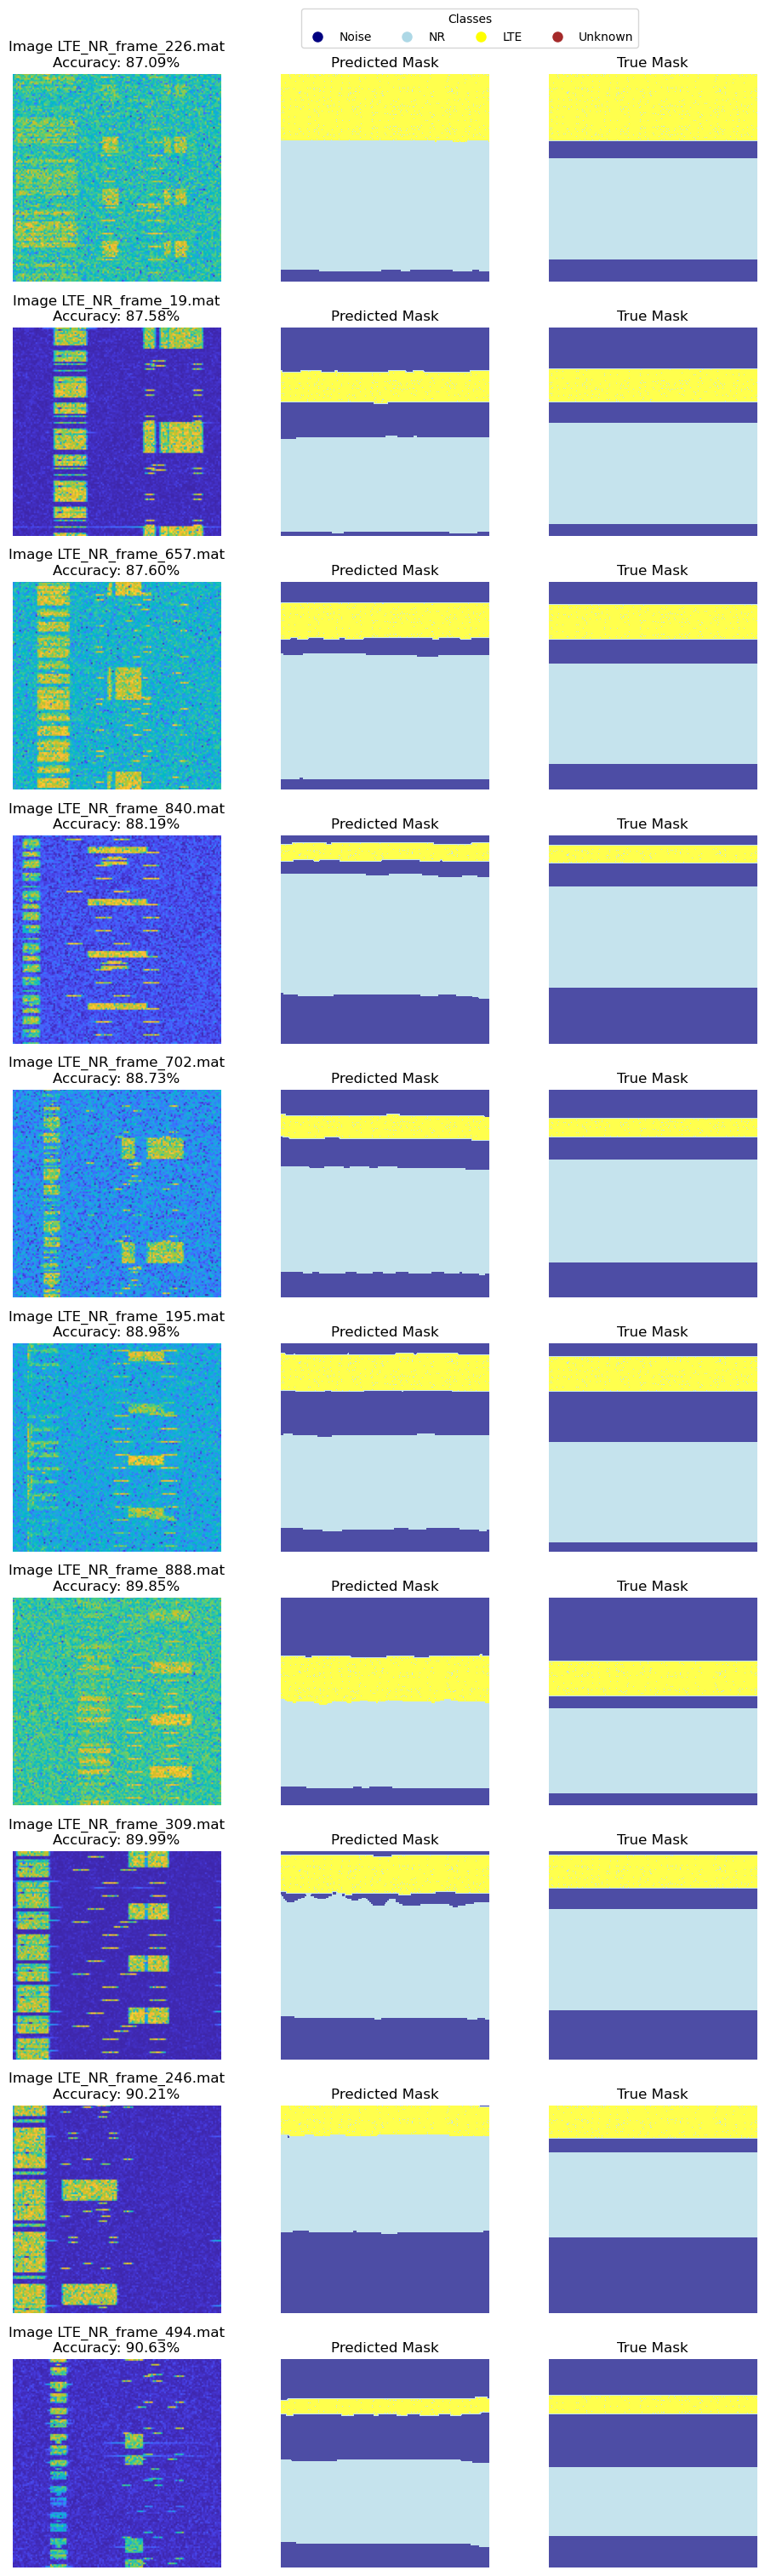

In [40]:
visualize_bottom_images(images_list, all_segmentation_preds, all_segmentation_labels, accuracies_list, class_names, top_n=10)


In [42]:
# Assuming you want to find the index for a specific file name
specific_file_name = 'LTE_NR_frame_226.mat'  # Replace with the file name you are looking for

# Find the index of the specific file name in the dataset
index = None
for i, file_name in enumerate(test_dataset.file_names):
    if file_name == specific_file_name:
        index = i
        break

# Check if the file name was found
if index is not None:
    print(f"The index of {specific_file_name} is {index}")
else:
    print(f"{specific_file_name} not found in the dataset.")


The index of LTE_NR_frame_226.mat is 91


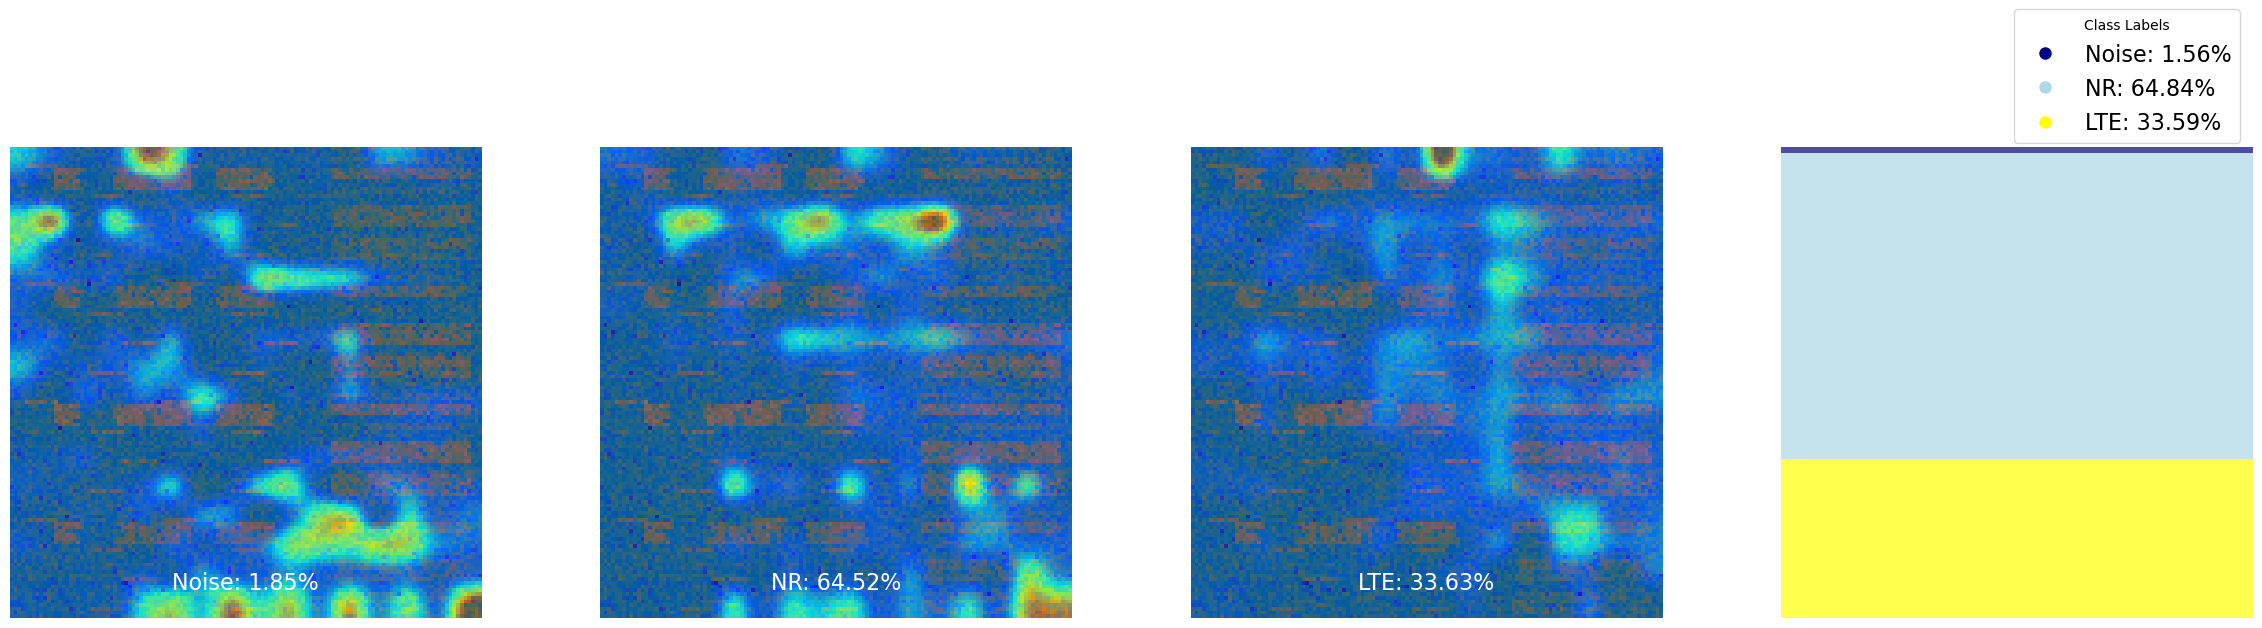

In [43]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F  # For applying softmax
from matplotlib.lines import Line2D

index = 15

# Assuming the class labels are stored in a list (example, modify with your actual class labels)
class_labels = ['Noise', 'NR', 'LTE']  # Example labels
num_classes = len(class_labels)

# Define hardcoded class colors (RGBA format or any other color format you prefer)
class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
]

# Create a custom colormap from the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)

# Reconstruct segmentation masks from ground truth labels (assuming labels are in integer format)
def reconstruct_segmentation_mask(labels):
    segmentation_mask = torch.zeros(labels.shape, dtype=torch.long)
    for class_idx in range(num_classes):
        segmentation_mask[labels == class_idx] = class_idx
    return segmentation_mask

# Create a function to compute class percentage in the segmentation mask
def compute_class_percentage(segmentation_mask):
    percentages = {}
    for class_idx in range(num_classes):
        total_pixels = segmentation_mask.numel()
        class_pixels = (segmentation_mask == class_idx).sum().item()
        percentages[class_labels[class_idx]] = (class_pixels / total_pixels) * 100
    return percentages


deeplab_model.eval()

# Select the last convolutional layer (DeepLabv3+ in SMP uses 'encoder.layer4')
cam_extractor = SmoothGradCAMpp(deeplab_model, target_layer="encoder.layer4")


# Load a spectrogram input (assuming it's preprocessed as a tensor)
input_image = images_test_tensor[index].unsqueeze(0)  # Select one image (batch size 1)
input_label = labels_test_tensor[index]
# Move the input image to the device
input_image = input_image.to(device)
input_label = input_label.to(device)

# Set requires_grad to True to track gradients for Grad-CAM
input_image.requires_grad_()

# Get the model output
output = deeplab_model(input_image)

# Apply softmax to get probabilities
output_probs = F.softmax(output, dim=1)  # Apply softmax over the classes (dim=1)

# Reconstruct the segmentation mask
segmentation_mask = reconstruct_segmentation_mask(input_label)

# Compute class percentages for the segmentation mask
mask_percentages = compute_class_percentage(segmentation_mask)

# Create a single figure for all plots with larger size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Increase figure size for better visibility

# Compute Grad-CAM for each class
for class_idx in range(output.size(1)):  # Loop over all the classes (output channels)
    # Compute Grad-CAM for the current class
    activation_map = cam_extractor(class_idx, output)
    
    # Overlay the heatmap on the spectrogram for the current class
    result = overlay_mask(to_pil_image(input_image.squeeze(0)), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    # Plot the result for the current class on the respective subplot
    ax = axes[class_idx]
    ax.imshow(result)
    ax.axis("off")
    
    # Get the probability of the current class by averaging over spatial dimensions (height, width)
    confidence_score = output_probs[0, class_idx].mean().item()  # Use mean over height and width
    predicted_label = class_labels[class_idx]  # Get the label corresponding to the class index
    
    # Add the label and score to the image (title)
    ax.set_title(f"{predicted_label}: {confidence_score*100:.2f}%", fontsize=16, color="white")

    # If title still does not show, try adding text directly on the image
    ax.text(0.5, 0.05, f"{predicted_label}: {confidence_score*100:.2f}%", ha='center', va='bottom', fontsize=16, color="white", transform=ax.transAxes)

# After the mask plot
mask_fig = axes[3]
mask_fig.imshow(segmentation_mask.cpu().numpy(), cmap=cmap, alpha=0.7)
mask_fig.axis("off")

# Add percentages directly on the segmentation mask plot
for class_idx in range(num_classes):
    # Compute the percentage for the current class
    percentage = mask_percentages[class_labels[class_idx]]
    
    # Get the position for placing the text (you can adjust these values as needed)
    y_position = (class_idx + 0.5) * (1 / num_classes)  # Adjust this to control vertical positioning
    


# Create custom legend handles for the segmentation classes with percentages
legend_labels = [f"{class_labels[class_idx]}: {mask_percentages[class_labels[class_idx]]:.2f}%" 
                 for class_idx in range(num_classes)]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) 
                  for c in class_colors]

# Add the legend to the plot with percentages in the labels
mask_fig.legend(legend_handles, legend_labels, title="Class Labels", loc="center left", bbox_to_anchor=(0.47, 1.15), fontsize=16)

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()


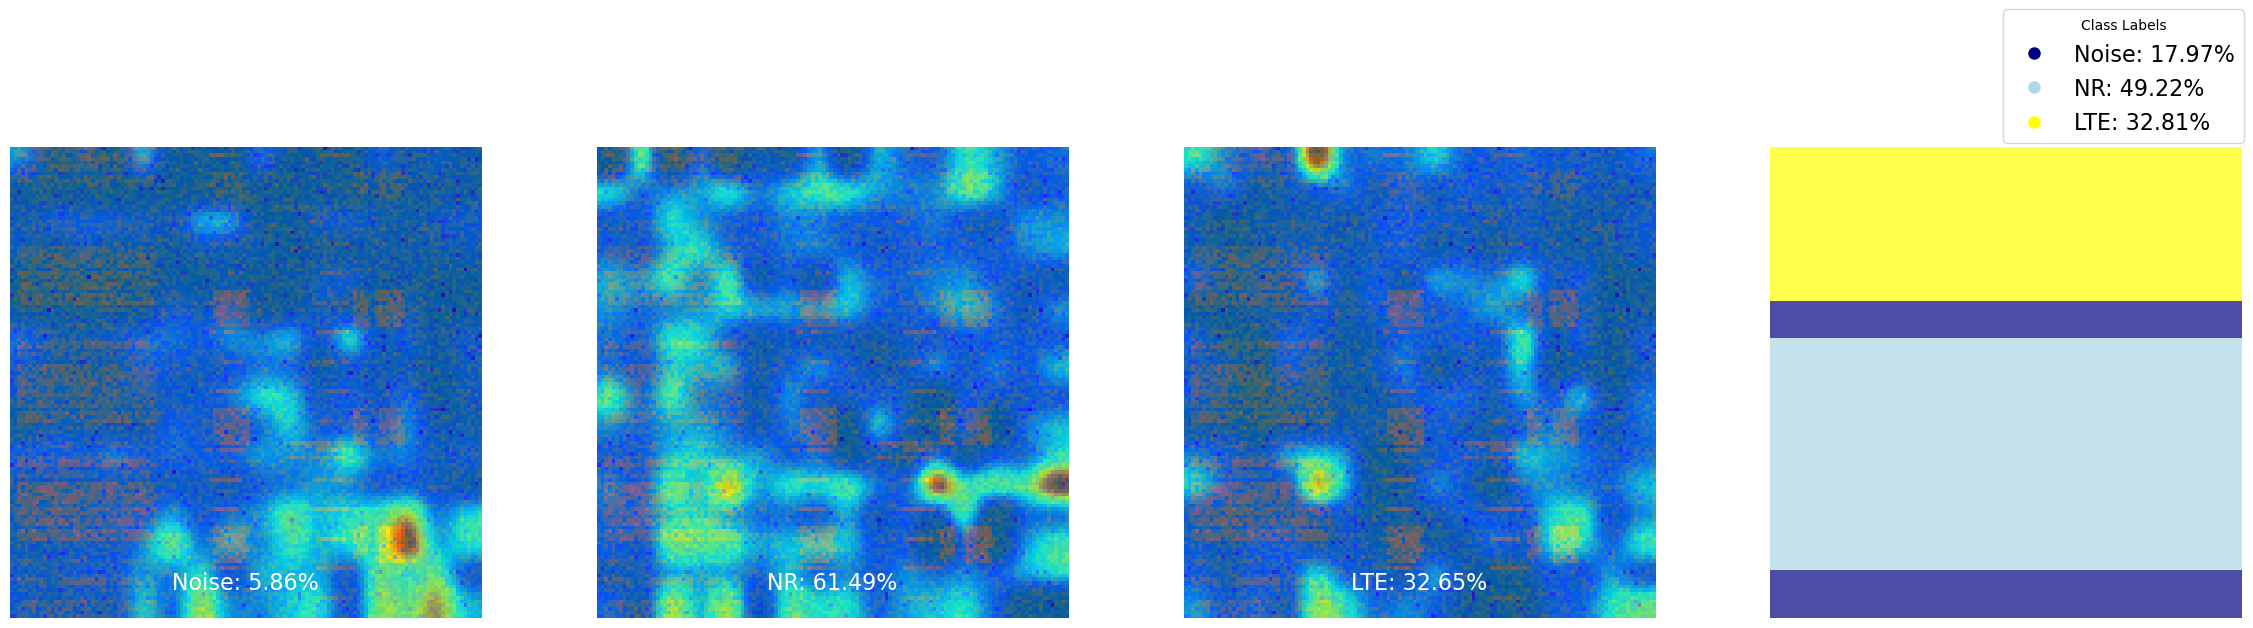

In [44]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F  # For applying softmax
from matplotlib.lines import Line2D

index = 91

# Assuming the class labels are stored in a list (example, modify with your actual class labels)
class_labels = ['Noise', 'NR', 'LTE']  # Example labels
num_classes = len(class_labels)

# Define hardcoded class colors (RGBA format or any other color format you prefer)
class_colors = [
    (0.0, 0.0, 0.5),  # Noise (Dark Blue)
    (0.678, 0.847, 0.902),  # NR (Light Blue)
    (1.0, 1.0, 0.0),  # LTE (Yellow)
]

# Create a custom colormap from the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)

# Reconstruct segmentation masks from ground truth labels (assuming labels are in integer format)
def reconstruct_segmentation_mask(labels):
    segmentation_mask = torch.zeros(labels.shape, dtype=torch.long)
    for class_idx in range(num_classes):
        segmentation_mask[labels == class_idx] = class_idx
    return segmentation_mask

# Create a function to compute class percentage in the segmentation mask
def compute_class_percentage(segmentation_mask):
    percentages = {}
    for class_idx in range(num_classes):
        total_pixels = segmentation_mask.numel()
        class_pixels = (segmentation_mask == class_idx).sum().item()
        percentages[class_labels[class_idx]] = (class_pixels / total_pixels) * 100
    return percentages


deeplab_model.eval()

# Select the last convolutional layer (DeepLabv3+ in SMP uses 'encoder.layer4')
cam_extractor = SmoothGradCAMpp(deeplab_model, target_layer="encoder.layer4")


# Load a spectrogram input (assuming it's preprocessed as a tensor)
input_image = images_test_tensor[index].unsqueeze(0)  # Select one image (batch size 1)
input_label = labels_test_tensor[index]
# Move the input image to the device
input_image = input_image.to(device)
input_label = input_label.to(device)

# Set requires_grad to True to track gradients for Grad-CAM
input_image.requires_grad_()

# Get the model output
output = deeplab_model(input_image)

# Apply softmax to get probabilities
output_probs = F.softmax(output, dim=1)  # Apply softmax over the classes (dim=1)

# Reconstruct the segmentation mask
segmentation_mask = reconstruct_segmentation_mask(input_label)

# Compute class percentages for the segmentation mask
mask_percentages = compute_class_percentage(segmentation_mask)

# Create a single figure for all plots with larger size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Increase figure size for better visibility

# Compute Grad-CAM for each class
for class_idx in range(output.size(1)):  # Loop over all the classes (output channels)
    # Compute Grad-CAM for the current class
    activation_map = cam_extractor(class_idx, output)
    
    # Overlay the heatmap on the spectrogram for the current class
    result = overlay_mask(to_pil_image(input_image.squeeze(0)), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    # Plot the result for the current class on the respective subplot
    ax = axes[class_idx]
    ax.imshow(result)
    ax.axis("off")
    
    # Get the probability of the current class by averaging over spatial dimensions (height, width)
    confidence_score = output_probs[0, class_idx].mean().item()  # Use mean over height and width
    predicted_label = class_labels[class_idx]  # Get the label corresponding to the class index
    
    # Add the label and score to the image (title)
    ax.set_title(f"{predicted_label}: {confidence_score*100:.2f}%", fontsize=16, color="white")

    # If title still does not show, try adding text directly on the image
    ax.text(0.5, 0.05, f"{predicted_label}: {confidence_score*100:.2f}%", ha='center', va='bottom', fontsize=16, color="white", transform=ax.transAxes)

# After the mask plot
mask_fig = axes[3]
mask_fig.imshow(segmentation_mask.cpu().numpy(), cmap=cmap, alpha=0.7)
mask_fig.axis("off")

# Add percentages directly on the segmentation mask plot
for class_idx in range(num_classes):
    # Compute the percentage for the current class
    percentage = mask_percentages[class_labels[class_idx]]
    
    # Get the position for placing the text (you can adjust these values as needed)
    y_position = (class_idx + 0.5) * (1 / num_classes)  # Adjust this to control vertical positioning
    


# Create custom legend handles for the segmentation classes with percentages
legend_labels = [f"{class_labels[class_idx]}: {mask_percentages[class_labels[class_idx]]:.2f}%" 
                 for class_idx in range(num_classes)]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) 
                  for c in class_colors]

# Add the legend to the plot with percentages in the labels
mask_fig.legend(legend_handles, legend_labels, title="Class Labels", loc="center left", bbox_to_anchor=(0.47, 1.15), fontsize=16)

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()


In [45]:
file_names_list[-10:]

['LTE_NR_frame_494.mat',
 'LTE_NR_frame_246.mat',
 'LTE_NR_frame_309.mat',
 'LTE_NR_frame_888.mat',
 'LTE_NR_frame_195.mat',
 'LTE_NR_frame_702.mat',
 'LTE_NR_frame_840.mat',
 'LTE_NR_frame_657.mat',
 'LTE_NR_frame_19.mat',
 'LTE_NR_frame_226.mat']

In [46]:
import pprint

# Extract metadata for the last 10 files
selected_metadata = {
    data['file_name']: data for data in processed_metadata_combined
    if data['file_name'] in file_names_list[-10:]
}




In [47]:

bottom_list = file_names_list[-10:]

In [48]:
bottom_list

['LTE_NR_frame_494.mat',
 'LTE_NR_frame_246.mat',
 'LTE_NR_frame_309.mat',
 'LTE_NR_frame_888.mat',
 'LTE_NR_frame_195.mat',
 'LTE_NR_frame_702.mat',
 'LTE_NR_frame_840.mat',
 'LTE_NR_frame_657.mat',
 'LTE_NR_frame_19.mat',
 'LTE_NR_frame_226.mat']

In [49]:
import torch
import pprint

# Assuming 'ranked_accuracies' and 'processed_metadata_combined' are already defined

# Bottom list - the last 10 files from file_names_list
bottom_list = file_names_list[-10:]

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the bottom_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in bottom_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy




In [50]:
import pandas as pd

# Assuming final_dict is already defined

# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)




In [51]:
# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Multiply accuracy by 100 and rename column
df_sorted["accuracy"] = df_sorted["accuracy"] * 100
df_sorted.rename(columns={"accuracy": "Accuracy (%)"}, inplace=True)
df_sorted.style.set_table_styles([{"selector": "th, td", "props": [("border", "1px solid black")]}])



In [52]:
file_names_list[0:10]

['LTE_NR_frame_507.mat',
 'LTE_NR_frame_41.mat',
 'LTE_NR_frame_272.mat',
 'LTE_NR_frame_936.mat',
 'LTE_NR_frame_80.mat',
 'LTE_NR_frame_64.mat',
 'LTE_NR_frame_650.mat',
 'LTE_NR_frame_886.mat',
 'LTE_NR_frame_640.mat',
 'LTE_NR_frame_841.mat']

In [53]:
import torch
import pprint

# Assuming 'ranked_accuracies' and 'processed_metadata_combined' are already defined

# Bottom list - the last 10 files from file_names_list
top_list = file_names_list[0:10]

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the bottom_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in top_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy



In [54]:
import pandas as pd

# Assuming final_dict is already defined

# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)



In [55]:
# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Multiply accuracy by 100 and rename column
df_sorted["accuracy"] = df_sorted["accuracy"] * 100
df_sorted.rename(columns={"accuracy": "Accuracy (%)"}, inplace=True)

df_sorted.style.set_table_styles([{"selector": "th, td", "props": [("border", "1px solid black")]}])


In [56]:
import torch
import pprint

# Assuming 'ranked_accuracies' and 'processed_metadata_combined' are already defined


files_list = file_names_list

# Step 1: Create a dictionary for the ranked accuracies with file names as keys
ranked_accuracies_dict = {fname: accuracy.item() for fname, accuracy in ranked_accuracies}

# Step 2: Create a new dictionary that combines only the 'params_without_info' and the accuracy for files in the files_list
final_dict = {}

for data in processed_metadata_combined:
    file_name = data['file_name']
    
    if file_name in files_list and file_name in ranked_accuracies_dict:
        # Extract only 'params_without_info' and accuracy
        data_with_accuracy = {
            'params_without_info': data['params_without_info'],
            'accuracy': ranked_accuracies_dict[file_name]
        }
        
        # Add to final dictionary
        final_dict[file_name] = data_with_accuracy

# Step 3: Pretty print the final dictionary
#pprint.pprint(final_dict)


In [57]:
import pandas as pd

# Assuming final_dict is already defined

# Step 1: Create an empty list to hold the rows for the DataFrame
data = []

# Step 2: Populate the list with dictionaries containing the file name, accuracy, and params_without_info
for file_name, info in final_dict.items():
    row = {
        'file_name': file_name,
        'accuracy': info['accuracy'],
        **info['params_without_info']  # Unpack the 'params_without_info' dictionary
    }
    data.append(row)

# Step 3: Convert the list of rows into a DataFrame
df = pd.DataFrame(data)

# Step 4: Print the DataFrame
print(df)



                file_name  accuracy  SCS  BW      SNRdB     Doppler  TrBlkOff
0    LTE_NR_frame_105.mat  0.966797   15  10  19.382172  332.015630         1
1    LTE_NR_frame_107.mat  0.985779   15  10  36.454463   93.951066         4
2    LTE_NR_frame_115.mat  0.931702   15  20  11.248939   65.490712         3
3    LTE_NR_frame_119.mat  0.955750   30  15  34.397787  438.351697         3
4    LTE_NR_frame_120.mat  0.937256   15  10  12.814915  356.092305         4
..                    ...       ...  ...  ..        ...         ...       ...
179  LTE_NR_frame_962.mat  0.958801   30  15   6.380676  114.340927         4
180  LTE_NR_frame_966.mat  0.975708   30  10  26.600222  272.409734         6
181  LTE_NR_frame_976.mat  0.979431   30  10  36.771823  375.976825         4
182  LTE_NR_frame_980.mat  0.928955   30  15  24.709211  439.713009         1
183  LTE_NR_frame_983.mat  0.952576   15  10  30.020821  347.386641         5

[184 rows x 7 columns]


In [58]:
# Rank the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='accuracy', ascending=False)

# Print the sorted DataFrame
print(df_sorted)


                file_name  accuracy  SCS  BW      SNRdB     Doppler  TrBlkOff
90   LTE_NR_frame_507.mat  0.998596   30  20   3.443430  334.190386         5
73    LTE_NR_frame_41.mat  0.996216   15  20  20.166720  145.110592         2
42   LTE_NR_frame_272.mat  0.995605   30  20   4.506694  148.002458         8
147   LTE_NR_frame_80.mat  0.995361   30  10  25.414111  186.577522         3
173  LTE_NR_frame_936.mat  0.995361   15   5  13.841007  494.469028         6
..                    ...       ...  ...  ..        ...         ...       ...
127  LTE_NR_frame_702.mat  0.887329   15   5   7.425359   27.444904         5
153  LTE_NR_frame_840.mat  0.881897   30   5  22.934209   70.208892         6
116  LTE_NR_frame_657.mat  0.876038   15  10   7.859636  331.040130         2
23    LTE_NR_frame_19.mat  0.875793   15  10  36.047729   89.926908         3
33   LTE_NR_frame_226.mat  0.870911   30  20   1.298985  470.761438         5

[184 rows x 7 columns]


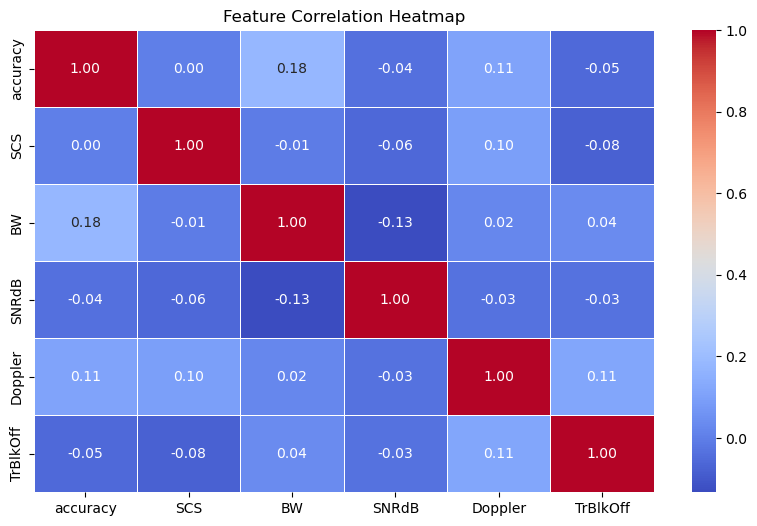

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'file_name' column
df_numeric = df_sorted.drop(columns=["file_name"])

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")
plt.show()


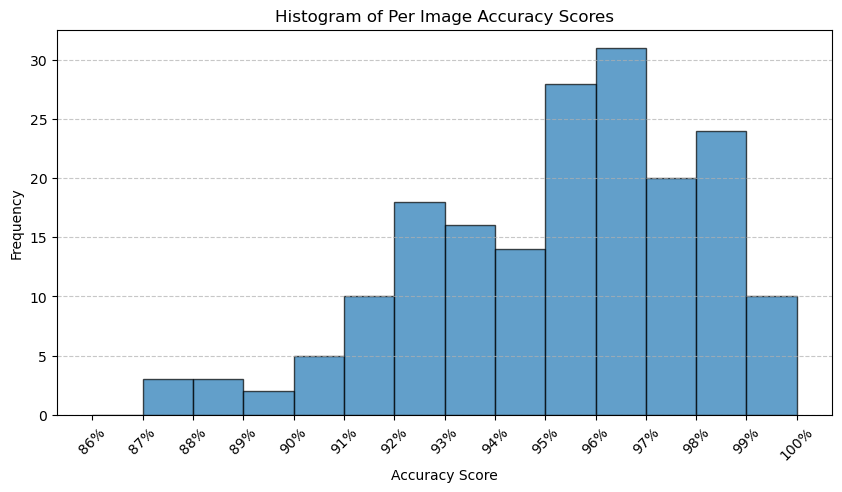

In [61]:
# Assuming ranked_accuracies is a list of (filename, accuracy) tuples
accuracies = [acc for _, acc in ranked_accuracies]
# Move accuracies to CPU and convert to a NumPy array
accuracies = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in accuracies]

# Define bins from 0.8 to 1 with interval of 0.02
bins = np.arange(0.86, 1.0, 0.01)

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(accuracies, bins=bins, edgecolor='black', alpha=0.7)

# Convert x-ticks to percentage
plt.xticks(bins, labels=[f"{int(b * 100)}%" for b in bins], rotation=45)

# Labels and title
plt.xlabel("Accuracy Score")
plt.ylabel("Frequency")
plt.title("Histogram of Per Image Accuracy Scores")
plt.xticks(bins, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [70]:
import optuna
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    num_epochs = trial.suggest_int('num_epochs', 5, 15)
    step_size = trial.suggest_int('step_size', 2, 10)
    gamma = trial.suggest_uniform('gamma', 0.1, 0.9)

    # Initialize the model and training loop
    deeplab_model = smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights="imagenet",
        encoder_output_stride=8,
        in_channels=3,
        classes=num_classes  # Number of output classes
    ).to(device)

    # Train the model
    train_model(train_loader, deeplab_model, num_classes=num_classes, num_epochs=num_epochs, 
                learning_rate=learning_rate, step_size=step_size, gamma=gamma, device=device)
    
    # Evaluate the model
    eval_result, _, _, _, _, _ = evaluate_model_with_snr_prediction_with_stats(
        deeplab_model, test_loader, device, num_classes)

    # Return the loss or metric you want to optimize (e.g., IoU or F1 score)
    return eval_result["segmentation_metrics"]["iou"]

# Define a study object
study = optuna.create_study(direction="minimize")  # 'minimize' since we want to minimize validation loss

# Start the optimization process
study.optimize(objective, n_trials=10)  # Number of trials to run

# After tuning, you can access the best hyperparameters
print(f"Best trial: {study.best_trial.params}")


[I 2025-03-05 16:37:27,671] A new study created in memory with name: no-name-dcbb86e1-7c2f-41e9-a661-61de316cfadd
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/7:   0%| 

Epoch 1/7 - Segmentation Loss: 1.6942


Epoch 2/7 - Segmentation Loss: 1.1905


Epoch 3/7 - Segmentation Loss: 0.8683


Epoch 4/7 - Segmentation Loss: 0.6464


Epoch 5/7 - Segmentation Loss: 0.5455


Epoch 6/7 - Segmentation Loss: 0.4483


Epoch 7/7 - Segmentation Loss: 0.3672


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.56batch/s]
[I 2025-03-05 16:38:43,250] Trial 0 finished with value: 0.8234426799317888 and parameters: {'learning_rate': 7.187897791939906e-05, 'num_epochs': 7, 'step_size': 5, 'gamma': 0.4564851014585015}. Best is trial 0 with value: 0.8234426799317888.


Validation Loss - Segmentation: 0.4697
Segmentation Metrics - Accuracy: 0.9023, F1: 0.9027, Precision: 0.9046, Recall: 0.9023
Segmentation IoU: 0.8234


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/12:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/12 - Segmentation Loss: 1.8703


Epoch 2/12 - Segmentation Loss: 1.6987


Epoch 3/12 - Segmentation Loss: 1.5544


Epoch 4/12 - Segmentation Loss: 1.3446


Epoch 5/12 - Segmentation Loss: 1.1719


Epoch 6/12 - Segmentation Loss: 1.0292


Epoch 7/12 - Segmentation Loss: 0.9316


Epoch 8/12 - Segmentation Loss: 0.8532


Epoch 9/12 - Segmentation Loss: 0.7739


Epoch 10/12 - Segmentation Loss: 0.7238


Epoch 11/12 - Segmentation Loss: 0.6670


Epoch 12/12 - Segmentation Loss: 0.6295


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.83batch/s]
[I 2025-03-05 16:40:47,889] Trial 1 finished with value: 0.7221171417239239 and parameters: {'learning_rate': 2.1259832310205105e-05, 'num_epochs': 12, 'step_size': 2, 'gamma': 0.7814032697914035}. Best is trial 1 with value: 0.7221171417239239.


Validation Loss - Segmentation: 0.8189
Segmentation Metrics - Accuracy: 0.8367, F1: 0.8375, Precision: 0.8392, Recall: 0.8367
Segmentation IoU: 0.7221


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/8:   0%|                                                                                | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/8 - Segmentation Loss: 1.9696


Epoch 2/8 - Segmentation Loss: 1.8827


Epoch 3/8 - Segmentation Loss: 1.8053


Epoch 4/8 - Segmentation Loss: 1.7351


Epoch 5/8 - Segmentation Loss: 1.6646


Epoch 6/8 - Segmentation Loss: 1.5644


Epoch 7/8 - Segmentation Loss: 1.4387


Epoch 8/8 - Segmentation Loss: 1.3360


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.20batch/s]
[I 2025-03-05 16:42:08,012] Trial 2 finished with value: 0.513596672296729 and parameters: {'learning_rate': 6.373782875400435e-06, 'num_epochs': 8, 'step_size': 7, 'gamma': 0.7184678970954217}. Best is trial 2 with value: 0.513596672296729.


Validation Loss - Segmentation: 1.4167
Segmentation Metrics - Accuracy: 0.6750, F1: 0.6775, Precision: 0.7099, Recall: 0.6750
Segmentation IoU: 0.5136


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/11:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/11 - Segmentation Loss: 1.9346


Epoch 2/11 - Segmentation Loss: 1.8779


Epoch 3/11 - Segmentation Loss: 1.8323


Epoch 4/11 - Segmentation Loss: 1.7790


Epoch 5/11 - Segmentation Loss: 1.7336


Epoch 6/11 - Segmentation Loss: 1.6951


Epoch 7/11 - Segmentation Loss: 1.6648


Epoch 8/11 - Segmentation Loss: 1.6550


Epoch 9/11 - Segmentation Loss: 1.6347


Epoch 10/11 - Segmentation Loss: 1.6168


Epoch 11/11 - Segmentation Loss: 1.5978


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.72batch/s]
[I 2025-03-05 16:43:51,186] Trial 3 finished with value: 0.42469759041053023 and parameters: {'learning_rate': 4.415758021493518e-06, 'num_epochs': 11, 'step_size': 6, 'gamma': 0.35752790214419106}. Best is trial 3 with value: 0.42469759041053023.


Validation Loss - Segmentation: 1.6651
Segmentation Metrics - Accuracy: 0.5932, F1: 0.5919, Precision: 0.6032, Recall: 0.5932
Segmentation IoU: 0.4247


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/15 - Segmentation Loss: 1.4280


Epoch 2/15 - Segmentation Loss: 0.8075


Epoch 3/15 - Segmentation Loss: 0.5901


Epoch 4/15 - Segmentation Loss: 0.4793


Epoch 5/15 - Segmentation Loss: 0.4283


Epoch 6/15 - Segmentation Loss: 0.3415


Epoch 7/15 - Segmentation Loss: 0.3097


Epoch 8/15 - Segmentation Loss: 0.3096


Epoch 9/15 - Segmentation Loss: 0.2372


Epoch 10/15 - Segmentation Loss: 0.1954


Epoch 11/15 - Segmentation Loss: 0.1842


Epoch 12/15 - Segmentation Loss: 0.1730


Epoch 13/15 - Segmentation Loss: 0.1430


Epoch 14/15 - Segmentation Loss: 0.1394


Epoch 15/15 - Segmentation Loss: 0.1299


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.43batch/s]
[I 2025-03-05 16:46:17,924] Trial 4 finished with value: 0.9051475357124391 and parameters: {'learning_rate': 0.00026297713714394443, 'num_epochs': 15, 'step_size': 8, 'gamma': 0.5185031123909559}. Best is trial 3 with value: 0.42469759041053023.


Validation Loss - Segmentation: 0.2642
Segmentation Metrics - Accuracy: 0.9500, F1: 0.9501, Precision: 0.9502, Recall: 0.9500
Segmentation IoU: 0.9051


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/6:   0%|                                                                                | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/6 - Segmentation Loss: 1.8859


Epoch 2/6 - Segmentation Loss: 1.8410


Epoch 3/6 - Segmentation Loss: 1.7979


Epoch 4/6 - Segmentation Loss: 1.7550


Epoch 5/6 - Segmentation Loss: 1.7162


Epoch 6/6 - Segmentation Loss: 1.6792


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.65batch/s]
[I 2025-03-05 16:47:22,422] Trial 5 finished with value: 0.38075050125611964 and parameters: {'learning_rate': 3.234493557903353e-06, 'num_epochs': 6, 'step_size': 10, 'gamma': 0.61207465196623}. Best is trial 5 with value: 0.38075050125611964.


Validation Loss - Segmentation: 1.8622
Segmentation Metrics - Accuracy: 0.5630, F1: 0.5365, Precision: 0.5531, Recall: 0.5630
Segmentation IoU: 0.3808


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/6:   0%|                                                                                | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/6 - Segmentation Loss: 1.8143


Epoch 2/6 - Segmentation Loss: 1.6560


Epoch 3/6 - Segmentation Loss: 1.4941


Epoch 4/6 - Segmentation Loss: 1.2822


Epoch 5/6 - Segmentation Loss: 1.1210


Epoch 6/6 - Segmentation Loss: 1.0149


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.73batch/s]
[I 2025-03-05 16:48:31,541] Trial 6 finished with value: 0.6202982875173142 and parameters: {'learning_rate': 1.6526201621569193e-05, 'num_epochs': 6, 'step_size': 10, 'gamma': 0.5413923093706544}. Best is trial 5 with value: 0.38075050125611964.


Validation Loss - Segmentation: 1.0705
Segmentation Metrics - Accuracy: 0.7619, F1: 0.7615, Precision: 0.7742, Recall: 0.7619
Segmentation IoU: 0.6203


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/11:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/11 - Segmentation Loss: 1.9558


Epoch 2/11 - Segmentation Loss: 1.9271


Epoch 3/11 - Segmentation Loss: 1.9026


Epoch 4/11 - Segmentation Loss: 1.8812


Epoch 5/11 - Segmentation Loss: 1.8522


Epoch 6/11 - Segmentation Loss: 1.8276


Epoch 7/11 - Segmentation Loss: 1.8089


Epoch 8/11 - Segmentation Loss: 1.7906


Epoch 9/11 - Segmentation Loss: 1.7736


Epoch 10/11 - Segmentation Loss: 1.7653


Epoch 11/11 - Segmentation Loss: 1.7541


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.34batch/s]
[I 2025-03-05 16:50:26,713] Trial 7 finished with value: 0.32752589542634114 and parameters: {'learning_rate': 1.6624068782166227e-06, 'num_epochs': 11, 'step_size': 8, 'gamma': 0.7208429706732683}. Best is trial 7 with value: 0.32752589542634114.


Validation Loss - Segmentation: 1.8041
Segmentation Metrics - Accuracy: 0.4711, F1: 0.4896, Precision: 0.5548, Recall: 0.4711
Segmentation IoU: 0.3275


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/10 - Segmentation Loss: 1.9031


Epoch 2/10 - Segmentation Loss: 1.8809


Epoch 3/10 - Segmentation Loss: 1.8588


Epoch 4/10 - Segmentation Loss: 1.8402


Epoch 5/10 - Segmentation Loss: 1.8184


Epoch 6/10 - Segmentation Loss: 1.8013


Epoch 7/10 - Segmentation Loss: 1.7764


Epoch 8/10 - Segmentation Loss: 1.7564


Epoch 9/10 - Segmentation Loss: 1.7436


Epoch 10/10 - Segmentation Loss: 1.7369


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.31batch/s]
[I 2025-03-05 16:52:07,361] Trial 8 finished with value: 0.3574633396659244 and parameters: {'learning_rate': 1.8823929319798744e-06, 'num_epochs': 10, 'step_size': 8, 'gamma': 0.3609425042723501}. Best is trial 7 with value: 0.32752589542634114.


Validation Loss - Segmentation: 1.7844
Segmentation Metrics - Accuracy: 0.5279, F1: 0.5138, Precision: 0.5079, Recall: 0.5279
Segmentation IoU: 0.3575


C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\2829679856.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
C:\Users\mathu\AppData\Local\Temp\ipykernel_17000\1201792391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/12:   0%|                                                                               | 0/46 [00:00<?, ?it/s]C:\Users\mat

Epoch 1/12 - Segmentation Loss: 1.3918


Epoch 2/12 - Segmentation Loss: 0.8394


Epoch 3/12 - Segmentation Loss: 0.6442


Epoch 4/12 - Segmentation Loss: 0.4837


Epoch 5/12 - Segmentation Loss: 0.4315


Epoch 6/12 - Segmentation Loss: 0.3953


Epoch 7/12 - Segmentation Loss: 0.3025


Epoch 8/12 - Segmentation Loss: 0.2363


Epoch 9/12 - Segmentation Loss: 0.2198


Epoch 10/12 - Segmentation Loss: 0.2042


Epoch 11/12 - Segmentation Loss: 0.1870


Epoch 12/12 - Segmentation Loss: 0.1874


Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.47batch/s]
[I 2025-03-05 16:54:10,584] Trial 9 finished with value: 0.8905686499137364 and parameters: {'learning_rate': 0.000246345218461561, 'num_epochs': 12, 'step_size': 6, 'gamma': 0.4351161292219069}. Best is trial 7 with value: 0.32752589542634114.


Validation Loss - Segmentation: 0.2939
Segmentation Metrics - Accuracy: 0.9419, F1: 0.9420, Precision: 0.9421, Recall: 0.9419
Segmentation IoU: 0.8906
Best trial: {'learning_rate': 1.6624068782166227e-06, 'num_epochs': 11, 'step_size': 8, 'gamma': 0.7208429706732683}
